In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [138]:
from gpt.wien_filter import WienFilter
from gpt.lattice import Lattice
from gpt.element import Screen

from distgen import Generator
from distgen import PHYSICAL_CONSTANTS
from distgen.writers import write_gpt

qe = PHYSICAL_CONSTANTS.species('electron')['charge'].magnitude
MC2 = PHYSICAL_CONSTANTS.species('electron')['mc2'].magnitude
c = PHYSICAL_CONSTANTS['speed of light in vacuum'].magnitude

from matplotlib import pyplot as plt
import numpy as np
import os


In [3]:
WF = WienFilter('WF1', 0.0001, 1, selection_energy=1e6)

In [4]:
WF.place()

In [5]:
WF.gpt_lines()

0


['\n',
 'WF1_x = 0;\n',
 'WF1_y = 0;\n',
 'WF1_yaw = 0;\n',
 'WF1_pitch = 0;\n',
 'WF1_roll = 0;\n',
 'WF1_a = 0.2;\n',
 'WF1_b = 0.2;\n',
 'WF1_L = 1;\n',
 'WF1_z = 0.5;\n',
 'WF1_E0 = 25769.600155281274;\n',
 'WF1_B0 = 0.0001;\n',
 'WF1_dipole_dl = 0;\n',
 'WF1_dipole_b1 = 0;\n',
 'WF1_dipole_b2 = 0;\n',
 '\n',
 'erect("wcs", "GxyzXYZ", WF1_x, WF1_y, WF1_z, WF1_yaw, WF1_pitch + 1.5707963267948966, WF1_roll, WF1_L, WF1_b, WF1_a, WF1_E0 );\n',
 'rectmagnet("wcs", "GxyzXYZ", WF1_x, WF1_y, WF1_z, WF1_yaw, WF1_pitch, WF1_roll, WF1_a, WF1_L, WF1_B0, WF1_dipole_dl, WF1_dipole_b1, WF1_dipole_b2 );\n']

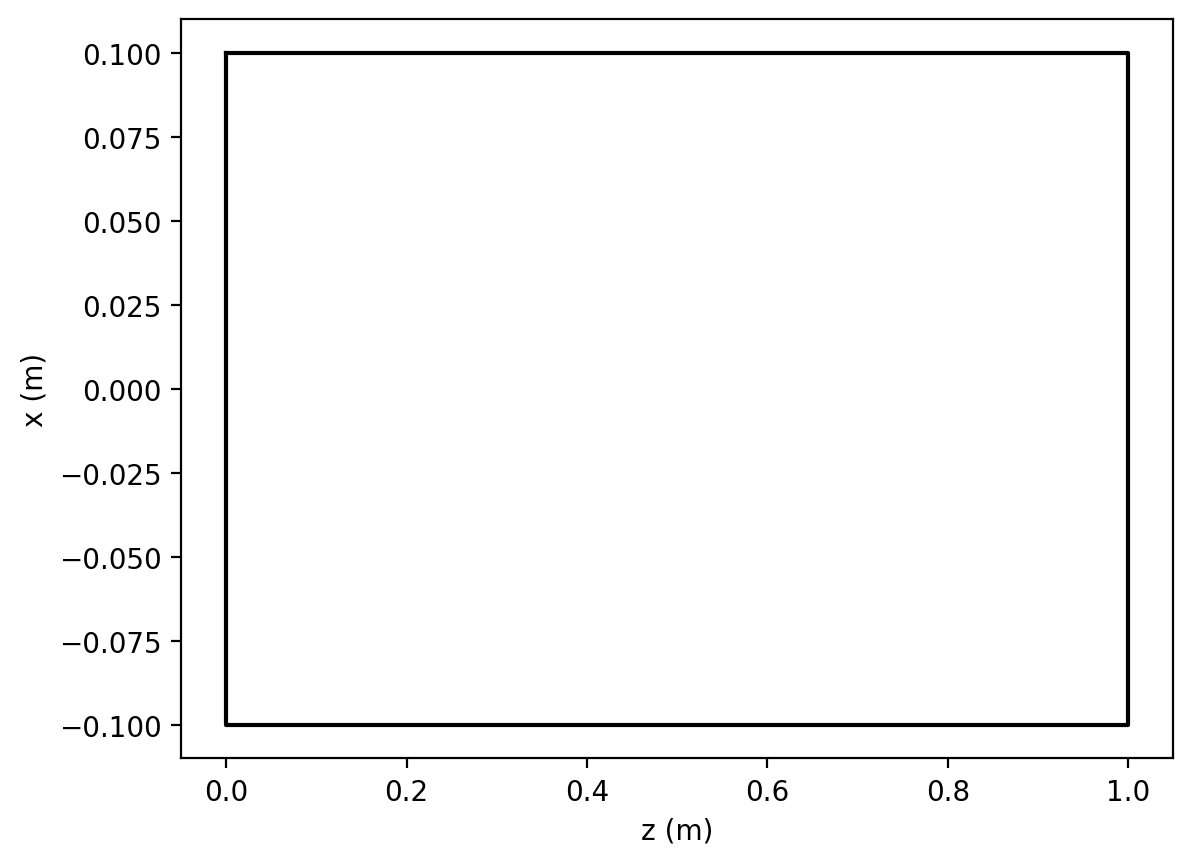

In [6]:
WF.plot_floor()

In [102]:
lat = Lattice('SR')
lat.add(WienFilter('WF1', 0.018962, 3.0, selection_energy=10e6), ds=0.5)
lat.add(Screen('scr1'), ds=1)

<Axes: xlabel='z (m)', ylabel='x (m)'>

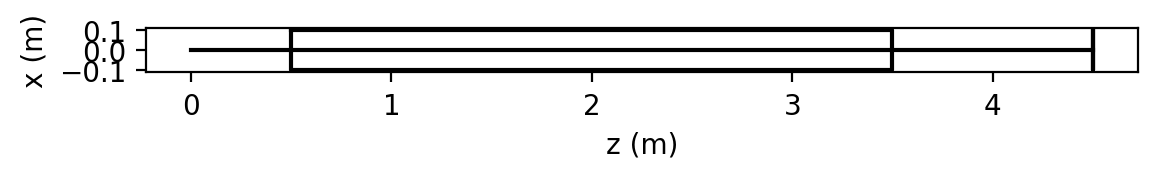

In [103]:
lat.plot_floor()

In [104]:
gpt_lines = lat.write_gpt_lines()

not a bend
no source data
not a bend
no source data
0
not a bend
no source data


In [105]:
with open('gpt.wf.temp.in', 'w') as fid:
    for line in gpt_lines:
        fid.write(line)

In [106]:
from gpt import GPT
from pmd_beamphysics import single_particle

In [107]:
G = GPT('gpt.wf.temp.in', 
        initial_particles = single_particle(pz = lat['WF1'].selection_momentum),
        load_fields=True,
        parse_layout=False
       )

In [108]:
G.set_variables({'Ntout': 500, 'ZSTOP':4.0, 'tmax': 50e-9})
G.run()

In [109]:
print(G)


GPT object:
   Original input file: gpt.wf.temp.in
   Template location: /Users/colwyngulliford/GitHub/lume-gpt/examples/elements
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/w8/8n1md1352pzd3nqp0lhc5jy00000gn/T/tmp10dm6h3t
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 0.1063387393951416 (sec)


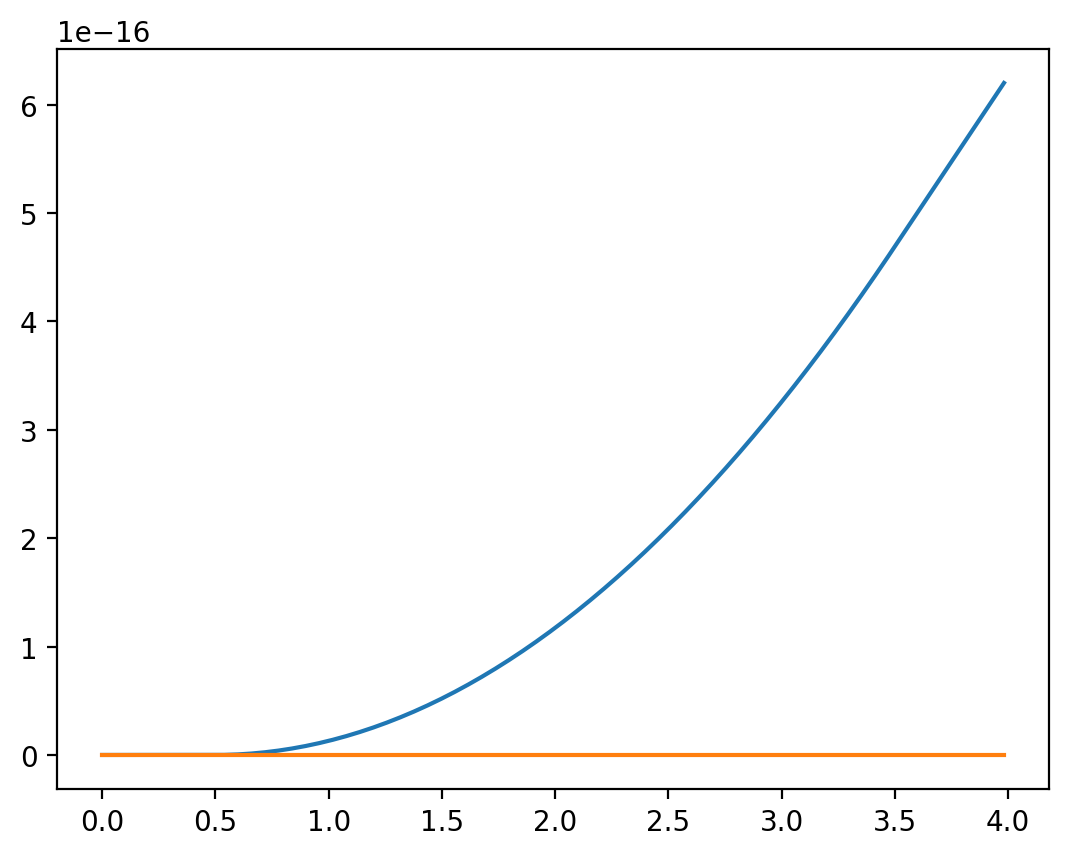

In [110]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_x'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_y'))

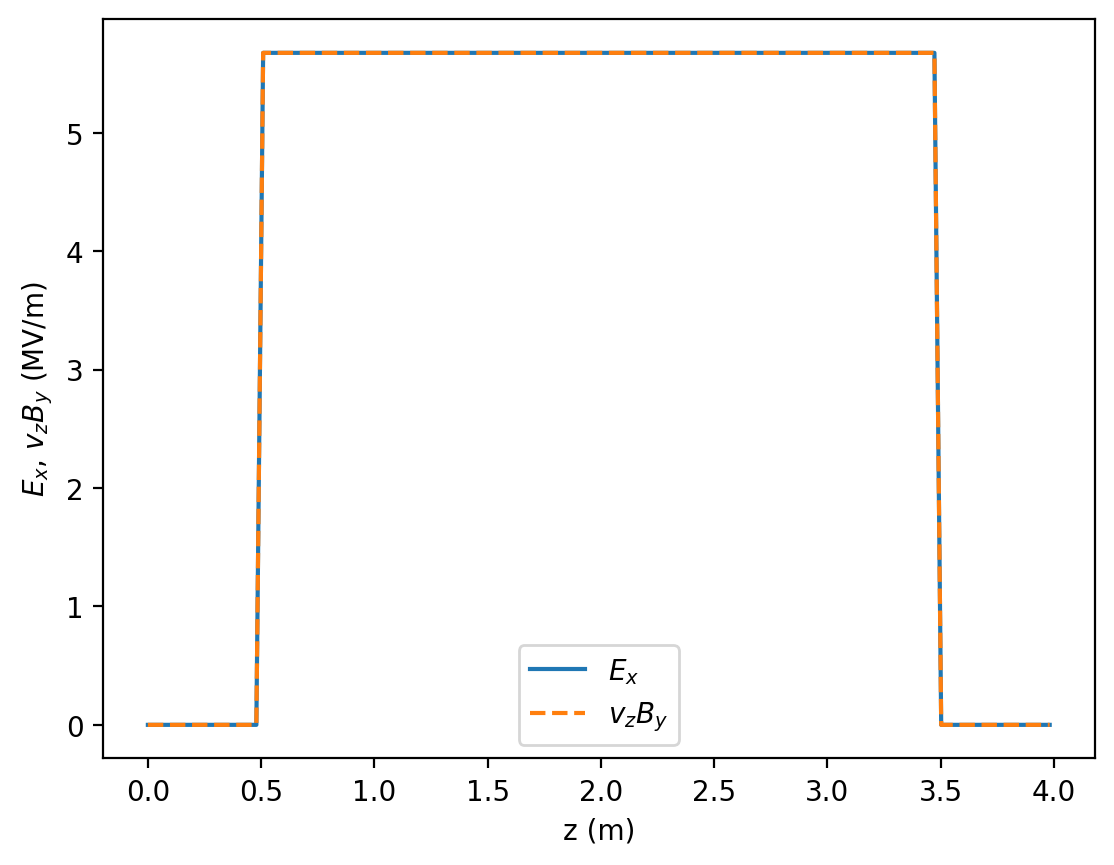

In [111]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_Ex')/1e6)
plt.plot(G.tout_stat('mean_z'), lat['WF1']._v0*G.tout_stat('mean_By')/1e6, '--')
plt.xlabel('z (m)') 
plt.ylabel(r'$E_x$, $v_zB_y$ (MV/m)')

plt.legend([r'$E_x$', '$v_zB_y$'])

In [112]:
n_particle = 1000

pz = lat['WF1'].selection_momentum

YAML=f"""
n_particle: {n_particle}
output:
  type: null
random:
  type: hammersley
species: electron
spin_polarization: 0.85
start:
  tstart:
    units: second
    value: 0
  type: time
total_charge:
  units: coulomb
  value: {n_particle*qe}
transforms:
  boost:
    type: set_avg pz
    avg_pz: {pz} eV/c
"""

D = Generator(YAML)
B = D.beam()

write_gpt(B, 'gpt_particles.gdf', asci2gdf_bin='$ASCI2GDF_BIN')

In [113]:
print(D)

<disgten.Generator with input: 
n_particle: 1000
output:
  type: null
random:
  type: hammersley
species: electron
spin_polarization: 0.85
start:
  tstart:
    units: second
    value: 0.0
  type: time
total_charge:
  units: coulomb
  value: -1.602176634e-16
transforms:
  boost:
    avg_pz:
      units: electron_volt / speed_of_light
      value: 9986935.46955659
    type: set_avg pz

>


In [114]:
G = GPT('gpt.wf.temp.in', 
        load_fields=True,
        spin_tracking=True,
        parse_layout=False)

In [115]:
G.set_variables({'Ntout': 500, 'ZSTOP':4.0, 'tmax': 50e-9})
G.run()

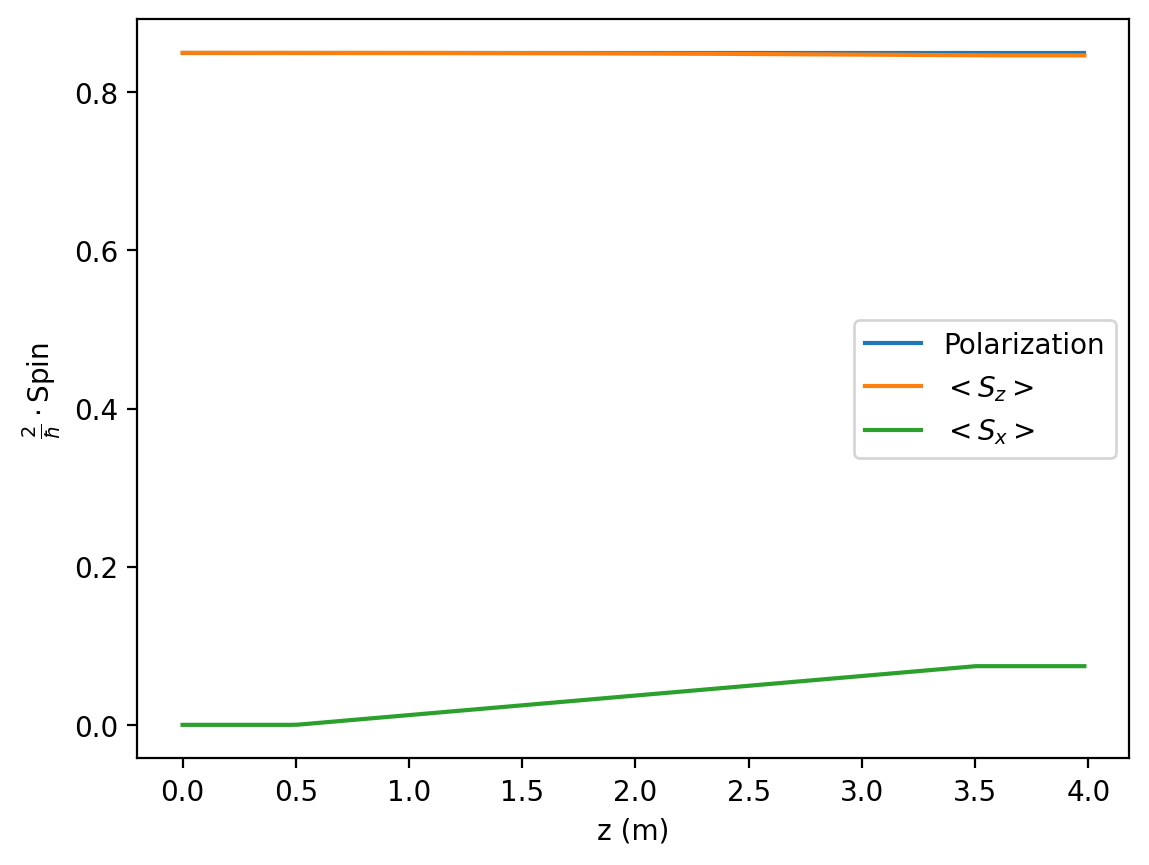

In [116]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('spin_polarization'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_sz'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_sx'))

plt.xlabel('z (m)')
plt.ylabel(r'$\frac{2}{\hbar}\cdot$Spin ')

plt.legend(['Polarization', '$<S_z>$', '$<S_x>$'])

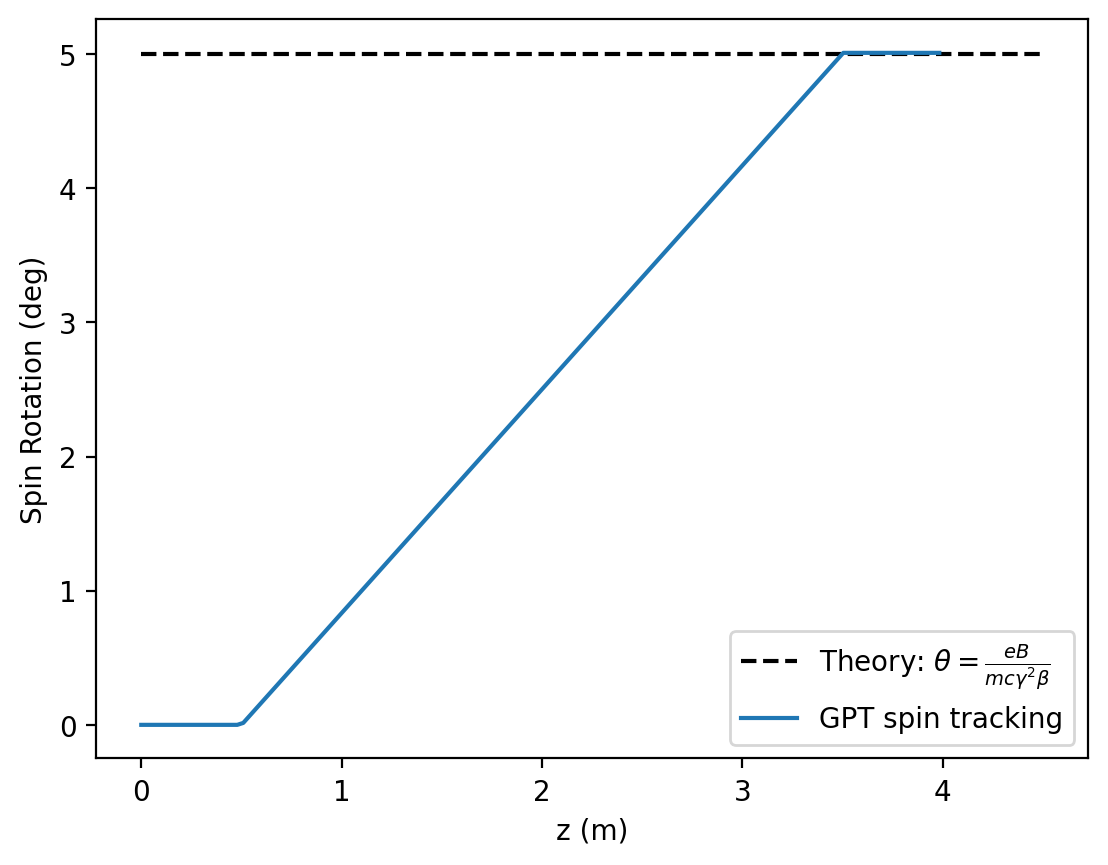

In [117]:
plt.plot([0, 4.5], [5, 5], '--k')
plt.plot(G.tout_stat('mean_z'), np.atan2(G.tout_stat('mean_sx'), G.tout_stat('mean_sz'))*180/np.pi)

#plt.plot(G.screen_stat('mean_z'), G.screen_stat('mean_sz'))
#plt.plot(G.screen_stat('mean_z'), G.screen_stat('mean_sx'))

plt.xlabel('z (m)')
plt.ylabel('Spin Rotation (deg)')
plt.legend([r'Theory: $\theta = \frac{eB}{mc\gamma^2\beta}$', 'GPT spin tracking', ])

In [118]:
def get_rotation(z, B, E):

    gamma = E/MC2

    beta = np.sqrt(1-1/gamma**2)

    return c*B * z / MC2 / gamma**2 / beta

In [120]:
get_rotation(3, 0.018961, 10e6) * 180/np.pi

np.float64(4.999350574981727)

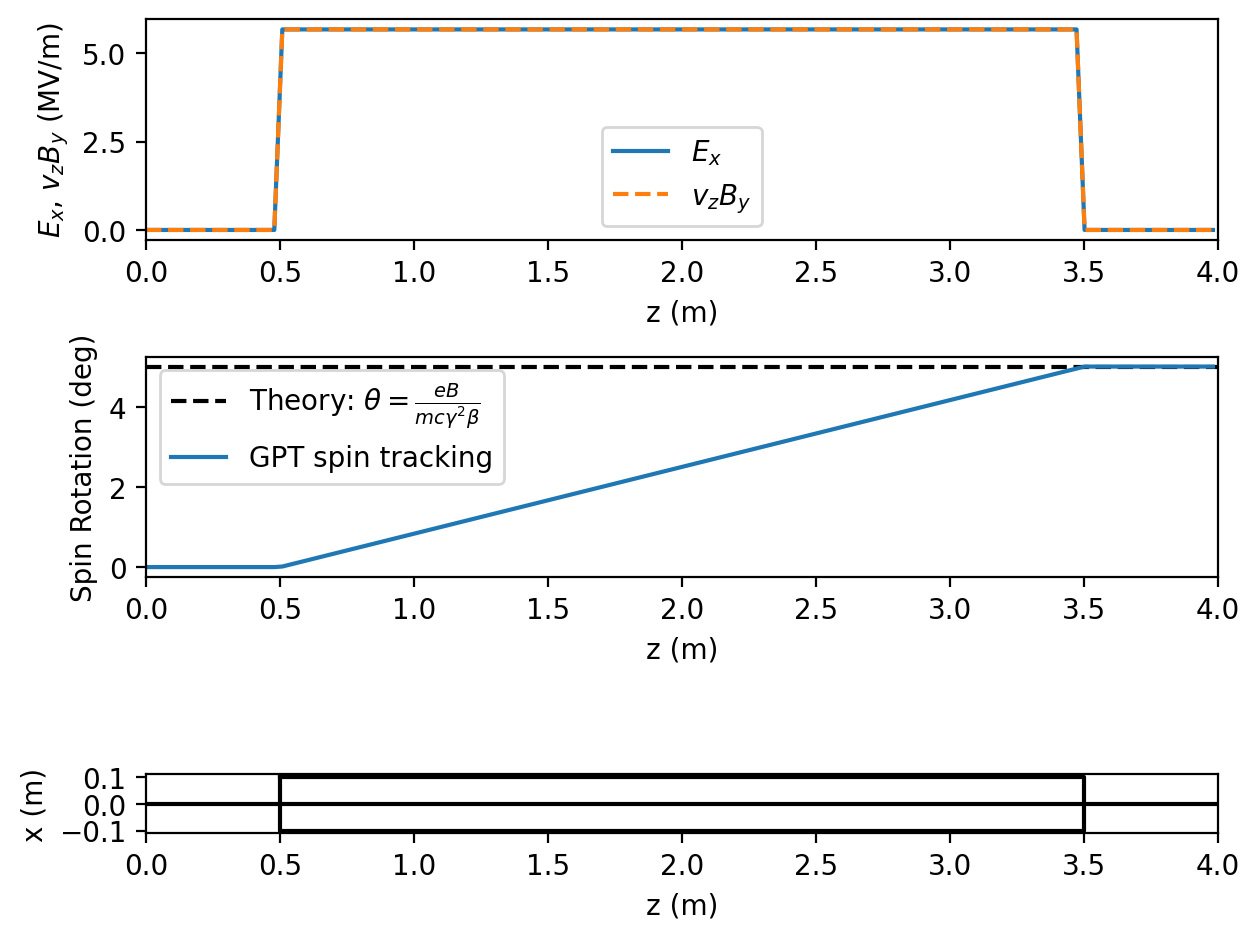

In [140]:
fig, axs = plt.subplots(3, 1)


axs[0].plot(G.tout_stat('mean_z'), G.tout_stat('mean_Ex')/1e6)
axs[0].plot(G.tout_stat('mean_z'), lat['WF1']._v0*G.tout_stat('mean_By')/1e6, '--')
axs[0].set_xlabel('z (m)') 
axs[0].set_ylabel(r'$E_x$, $v_zB_y$ (MV/m)')

axs[0].legend([r'$E_x$', '$v_zB_y$'])

axs[1].plot([0, 4.5], [5, 5], '--k')
axs[1].plot(G.tout_stat('mean_z'), np.atan2(G.tout_stat('mean_sx'), G.tout_stat('mean_sz'))*180/np.pi)

axs[1].set_xlabel('z (m)')
axs[1].set_ylabel('Spin Rotation (deg)')
axs[1].legend([r'Theory: $\theta = \frac{eB}{mc\gamma^2\beta}$', 'GPT spin tracking', ])


lat.plot_floor(ax=axs[-1])

for ii in range(len(axs)):
    axs[ii].set_xlim([0, 4])

plt.tight_layout()

plt.savefig('10MeV_Wien_Filter_example.pdf')

In [139]:
os.remove('gpt_particles.gdf')
os.remove('gpt.wf.temp.in')